In [129]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [130]:
import pandas as pd
cap = pd.read_csv("/Users/houzhuo/Downloads/capdata3.csv")
robot    = pd.read_csv("/Users/houzhuo/Downloads/robot.csv")
full = pd.concat([cap,robot],axis=1)
full.head()

,No,1,2,3,4,5,6,7,8,9,...,Shoulder_L,Hiproll_R,Shoulder_R,Hip,Moe,Hip_R,Head,Shoulder_peach_L,Head_pitch,Shoulder_pitch_R
0,1,-70.2093,77.6512,-2.40005,-30.6520,-70.7097,-18.5101,-1.48789,6.43077,-90.1392,...,-2016.000000,0.000000,2199.000000,0.0,261.000000,0.0,916.000000,1072.0,-271.0,-1028.0
1,2,-70.2093,77.6512,-2.40005,-30.0076,-70.6074,-17.7873,-1.51620,6.45095,-90.1584,...,-2018.228261,-5.869565,2193.141304,0.0,261.608696,0.0,917.586956,1072.0,-271.0,-1028.0
2,3,-70.2093,77.6512,-2.40005,-29.4269,-70.5241,-17.1182,-1.53064,6.46612,-90.1798,...,-2020.456522,-11.739130,2187.282609,0.0,262.217391,0.0,919.173913,1072.0,-271.0,-1028.0
3,4,-70.2093,77.6512,-2.40005,-28.9343,-70.4591,-16.5383,-1.52306,6.47134,-90.2022,...,-2022.684783,-17.608696,2181.423913,0.0,262.826087,0.0,920.760870,1072.0,-271.0,-1028.0
4,5,-70.2093,77.6512,-2.40005,-28.3700,-70.3946,-15.9114,-1.51531,6.47130,-90.2185,...,-2024.913043,-23.478261,2175.565217,0.0,263.434783,0.0,922.347826,1072.0,-271.0,-1028.0


In [141]:
cap_headx = full['76']
cap_heady = full['77']
cap_headz = full['78']
#cap_head = pd.concat(cap_headx,cap_heady,cap_headz)
dataset = pd.concat( [  full['Head'],full['76'],full['77'],full['78'] ] , axis=1 )
dataset.head()
type(dataset)

pandas.core.frame.DataFrame

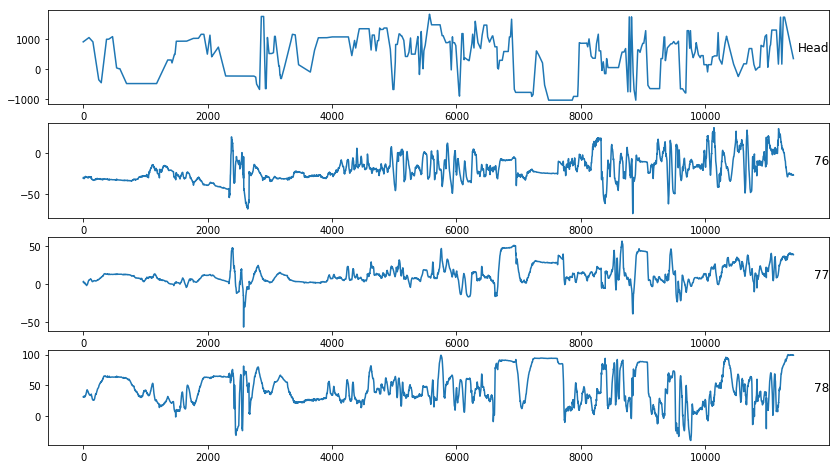

In [142]:
import matplotlib.pyplot as plt
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i=1
plt.figure(figsize=(14,8))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [144]:


import numpy as np
values = dataset.values
values = dataset.astype(np.float32)
#values -= np.mean(values, axis = 0)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
#reframed = series_to_supervised(scaled, 1, 1)
time_step=3
n_features=4
reframed = series_to_supervised(scaled, time_step, 1)

print(reframed.shape)
reframed.head()

(11417, 16)


,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
3,0.678209,0.412781,0.526011,0.508022,0.678764,0.418129,0.529421,0.509774,0.679319,0.421799,0.531716,0.510982,0.679874,0.421625,0.531912,0.511256
4,0.678764,0.418129,0.529421,0.509774,0.679319,0.421799,0.531716,0.510982,0.679874,0.421625,0.531912,0.511256,0.680429,0.420697,0.531621,0.510959
5,0.679319,0.421799,0.531716,0.510982,0.679874,0.421625,0.531912,0.511256,0.680429,0.420697,0.531621,0.510959,0.680985,0.419909,0.531468,0.510079
6,0.679874,0.421625,0.531912,0.511256,0.680429,0.420697,0.531621,0.510959,0.680985,0.419909,0.531468,0.510079,0.681540,0.418822,0.530849,0.508875
7,0.680429,0.420697,0.531621,0.510959,0.680985,0.419909,0.531468,0.510079,0.681540,0.418822,0.530849,0.508875,0.682095,0.417390,0.529380,0.507321


In [145]:
values = reframed.values
train = values[:8000,:]
val = values[8000:10000,:]
test = values[10000:,:]

n_obs = time_step*n_features
train_X,train_y = train[:,:n_obs],train[:,-n_features]
val_X,val_y = val[:,:n_obs],val[:,-n_features]#第一个多少行
test_X,test_y = test[:,:n_obs],test[:,-n_features]
print(train_X.shape,train_y.shape)

(8000, 12) (8000,)


In [153]:
train_X = train_X.reshape(train_X.shape[0],time_step,n_features)
val_X = val_X.reshape(val_X.shape[0],time_step,n_features)
test_X = test_X.reshape(test_X.shape[0],time_step,n_features)
print(train_X.shape,train_y.shape,val_X.shape,val_y.shape,test_X.shape,test_y.shape)

(8000, 3, 4) (8000,) (2000, 3, 4) (2000,) (1417, 3, 4) (1417, 1)


Train on 8000 samples, validate on 2000 samples
Epoch 1/50
 - 4s - loss: 0.1165 - val_loss: 0.2271
Epoch 2/50
 - 2s - loss: 0.0431 - val_loss: 0.0487
Epoch 3/50
 - 2s - loss: 0.0230 - val_loss: 0.0269
Epoch 4/50
 - 2s - loss: 0.0190 - val_loss: 0.0311
Epoch 5/50
 - 2s - loss: 0.0185 - val_loss: 0.0257
Epoch 6/50
 - 2s - loss: 0.0171 - val_loss: 0.0236
Epoch 7/50
 - 2s - loss: 0.0150 - val_loss: 0.0498
Epoch 8/50
 - 2s - loss: 0.0154 - val_loss: 0.0729
Epoch 9/50
 - 2s - loss: 0.0157 - val_loss: 0.0464
Epoch 10/50
 - 2s - loss: 0.0124 - val_loss: 0.0337
Epoch 11/50
 - 2s - loss: 0.0132 - val_loss: 0.0250
Epoch 12/50
 - 2s - loss: 0.0123 - val_loss: 0.0258
Epoch 13/50
 - 2s - loss: 0.0144 - val_loss: 0.0287
Epoch 14/50
 - 2s - loss: 0.0135 - val_loss: 0.0422
Epoch 15/50
 - 3s - loss: 0.0142 - val_loss: 0.0219
Epoch 16/50
 - 3s - loss: 0.0140 - val_loss: 0.0292
Epoch 17/50
 - 3s - loss: 0.0126 - val_loss: 0.0527
Epoch 18/50
 - 2s - loss: 0.0146 - val_loss: 0.0149
Epoch 19/50
 - 2s - loss:

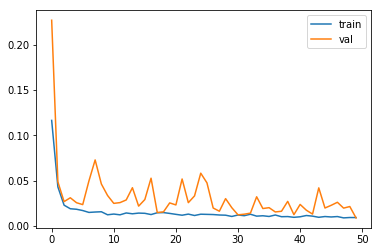

In [154]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=20, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [149]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], time_step*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 42.890


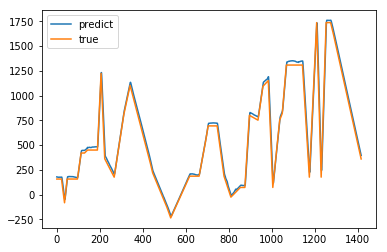

In [150]:
plt.figure()
plt.plot(inv_yhat, label = 'predict')
plt.plot(inv_y, label = 'true')
plt.legend()
plt.show()

In [151]:
inv_yhat

array([178.46969569, 177.7656481 , 177.02325833, ..., 415.17351186,
       405.51034579, 395.80338442])

In [152]:
inv_y

array([157.        , 157.        , 157.        , ..., 379.54544067,
       369.7727356 , 360.        ])